In [1]:
import numpy as np
import tensorflow as tf
import glob 
import pandas as pd
import h5py # import to read hdf5
from pathlib import Path
from tqdm import tqdm

In [2]:
TRAIN = True

In [3]:
def load_df(train=True):
    root = "/Volumes/T7/gravitational-waves/kaggle-data"
    if train:
        # Load /Users/viktorcikojevic/Documents/gravitational-waves-detection-kaggle/train_labels.csv as pandas dataframe
        df = pd.read_csv(f'{root}/train_labels.csv')
        root_folder = f"{root}/train"
        # Rename the column 'id' to 'filename'. Add "root_folder" to the beginning of the filename
        df['filename'] = root_folder + "/" + df['id'].astype(str) + ".hdf5"
        df.head(5)
    else:
        df = pd.DataFrame({'filename': glob.glob(f'{root}/test/*.hdf5')})
    return df

df = load_df(train=TRAIN)

# Read file function 👀

In [4]:

# Each vector x has shape (4, 360, N). If N is not a multiple of 360, then we need to pad the vector with random noise with mu=np.average(x) and sigma=np.std(x)
def pad_amplitudes(x1, x2):
    # Get the shape of the vectors
    shape1 = x1.shape
    shape2 = x2.shape
    # Get the number of elements in each vector
    n1 = shape1[1]
    n2 = shape2[1]
    # Get the number of elements to pad
    n_pad = abs(n1 - n2)
    # Get the average and std of each vector
    mu1 = np.average(x1)
    mu2 = np.average(x2)
    sigma1 = np.std(x1)
    sigma2 = np.std(x2)
    # Get the padding vector
    pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
    pad2 = np.random.normal(mu2, sigma2, (360, n_pad))
    # Pad the shorter vector
    if n1 > n2:
        x2 = np.concatenate((x2, pad2), axis=1)
    else:
        x1 = np.concatenate((x1, pad1), axis=1)
    return x1, x2


def pad_vector(x):
    if x.shape[2] % 360 != 0:
        mu = np.average(x)
        sigma = np.std(x)
        padding = np.random.normal(mu, sigma, (4, x.shape[1],360 - x.shape[2] % 360))
        x = np.concatenate((x, padding), axis=1)
    return x

def combine_amplitudes(amplitude_0, amplitude_1):
    
    amplitude_0, amplitude_1 = pad_amplitudes(amplitude_0, amplitude_1)
    # Get the real part of the amplitudes
    real_0 = amplitude_0.real
    real_1 = amplitude_1.real
    # Get the imaginary part of the amplitudes
    imag_0 = amplitude_0.imag
    imag_1 = amplitude_1.imag
    # normalize the amplitudes to be between 0 and 1
    real_0 = (real_0 - real_0.min()) / (real_0.max() - real_0.min())
    real_1 = (real_1 - real_1.min()) / (real_1.max() - real_1.min())
    imag_0 = (imag_0 - imag_0.min()) / (imag_0.max() - imag_0.min())
    imag_1 = (imag_1 - imag_1.min()) / (imag_1.max() - imag_1.min())
    # Expand the dims of the real and imaginary parts
    real_0 = np.expand_dims(real_0, axis=0)
    real_1 = np.expand_dims(real_1, axis=0)
    imag_0 = np.expand_dims(imag_0, axis=0)
    imag_1 = np.expand_dims(imag_1, axis=0)
    # Make a vstack of the amplitudes
    amplitudes = np.vstack((real_0, imag_0, real_1, imag_1))
    return amplitudes



# Idea from this function takes from this notebook (😇): https://www.kaggle.com/code/ayuraj/g2net-understand-the-data
def read_data(file):
    file = Path(file)
    with h5py.File(file, "r") as f:
        filename = file.stem
        f = f[filename]
        h1 = f["H1"]
        l1 = f["L1"]
        freq_hz = list(f["frequency_Hz"])
        
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        # H2 data
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        return combine_amplitudes(h1_stft, l1_stft)


In [52]:
x = read_data(df.iloc[7]['filename'])
x = np.swapaxes(x, 1, 2)
print(df.iloc[7]['filename'])

/Volumes/T7/gravitational-waves/kaggle-data/train/01bcf6533.hdf5


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_34557/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_34557/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


In [53]:
df.head(5)

,id,target,filename
0,001121a05,1,/Volumes/T7/gravitational-waves/kaggle-data/tr...
1,004f23b2d,1,/Volumes/T7/gravitational-waves/kaggle-data/tr...
2,00a6db666,1,/Volumes/T7/gravitational-waves/kaggle-data/tr...
3,00f36a6ac,1,/Volumes/T7/gravitational-waves/kaggle-data/tr...
4,010a387db,1,/Volumes/T7/gravitational-waves/kaggle-data/tr...


In [54]:
df[df['target'] == 0]

,id,target,filename
7,01bcf6533,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
11,029ed046c,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
13,02c8f43f3,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
20,05cdc0769,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
23,06e321c6e,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
...,...,...,...
584,f773f83db,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
587,f8792034c,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
588,f8cd7e52f,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...
591,f9ce02fd5,0,/Volumes/T7/gravitational-waves/kaggle-data/tr...


In [55]:
x.shape

(4, 4512, 360)

In [56]:
np.swapaxes(x, 1, 2).shape

(4, 360, 4512)

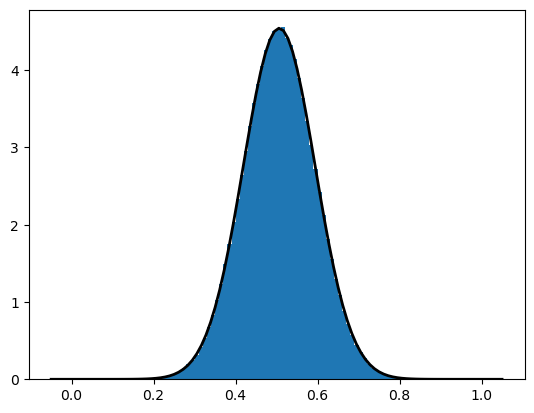

In [60]:
x_flatten = x[2].flatten()
# Plot the histogram of the flattened vector  
plt.hist(x_flatten, bins=100, density=True)
# Import norm.fit from scipy.stats
from scipy.stats import norm
# Fit with gaussian
(mu, sigma) = norm.fit(x_flatten)
# Plot the gaussian on the same plot
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_range, mu, sigma)
plt.plot(x_range, p, 'k', linewidth=2)

In [61]:
x[3].shape

(4512, 360)

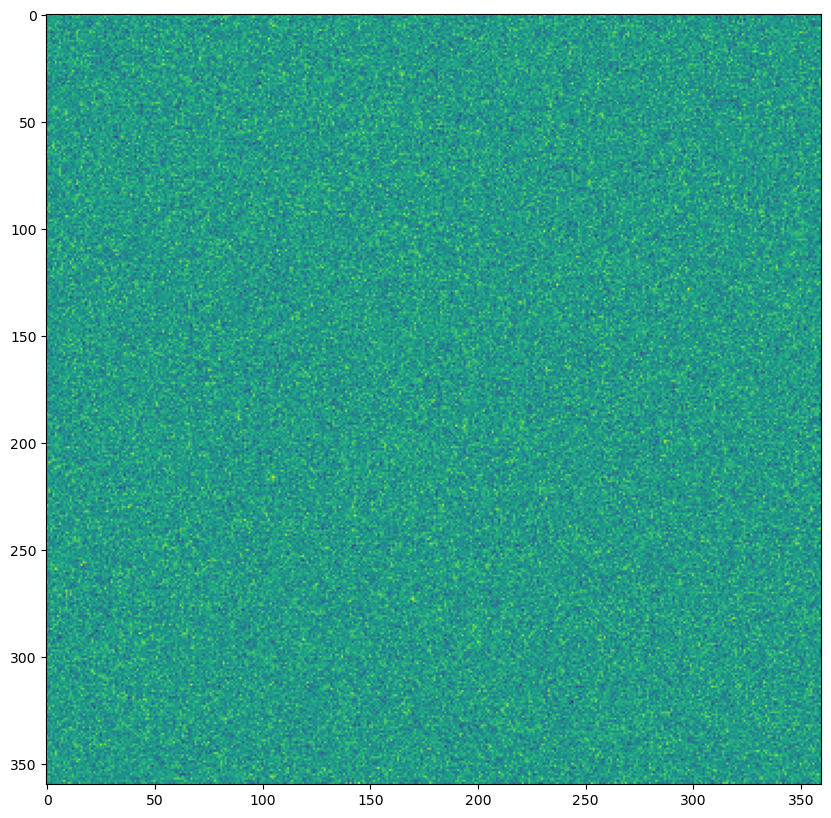

In [69]:
# Visualize x
import matplotlib.pyplot as plt
# Make large figure
plt.figure(figsize=(10, 10))
s = 10
plt.imshow(x[0][s*360:s*360+360], aspect='auto', cmap='viridis')

In [39]:
# Each vector x has shape (4, 360, N). If N is not a multiple of 360, then we need to pad the vector with random noise with mu=np.average(x) and sigma=np.std(x)
def pad_vector(x):
    if x.shape[1] % 360 != 0:
        mu = np.average(x)
        sigma = np.std(x)
        padding = np.random.normal(mu, sigma, (4, 360 - x.shape[1] % 360, x.shape[2]))
        x = np.concatenate((x, padding), axis=1)
    return x

In [40]:
# Each vector x has shape (4, 360, N). Loop over the vector and slice it into vectors of shape (4, 360, 360). If N is not a multiple of 360, then we need to pad the vector with random noise with mu=np.average(x) and sigma=np.std(x) before slicing
# Return a list of vectors
def slice_vector(x):
    x = pad_vector(x)
    slices = []
    for i in range(x.shape[2] // 360):
        slices.append(x[:, :, i * 360 : (i + 1) * 360])
    return np.array(slices)

In [41]:
# For a given vector (M, 4, 360, 360) and model, return the predictions of the model

def get_predictions(x, model):
    x = tf.convert_to_tensor(x)
    return model.predict(x)
    predictions = []
    for i in range(x.shape[0]):
        predictions.append(model.predict(x[i].reshape(1, 4, 360, 360)))
    return np.array(predictions)

In [42]:

def get_model(path):
    # Create a ResNet model. Load from keras.applications.resnet50.ResNet50
    from tensorflow.keras.applications.resnet50 import ResNet50
    # Create a ResNet50 model with weights not pre-trained on  ImageNet. Set include_top to False.  Set input_shape to (360, 360, 4). Set pooling to 'avg'. Classify into 2 classes. Activate sigmoid function.
    resnet = ResNet50(weights=None, include_top=False, input_shape=(360, 360, 4), pooling='avg', classes=1)
    model = tf.keras.Sequential([
        tf.keras.layers.Permute((2, 3, 1), input_shape=(4, 360, 360)),
        resnet,
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.load_weights(path)
    return model

In [43]:
model_paths = {
    "mix-gamma-4": "../../../trained-models/run-20221030_154453-3ua05fk1/files/model-best.h5",
    # "h0=0.1": "../../../trained-models/run-20221030_154818-4lrmhtxo/files/model-best.h5",
    # "h0=0.2": "../../../trained-models/run-20221030_154903-sa3eoy63/files/model-best.h5",
    # "mix-gamma-4-more-data": "../../../trained-models/run-20221101_220800-1sei79yc/files/model-best.h5",
    # "mix-gamma-2": "../../../trained-models/run-20221101_220810-3ao4yzcd/files/model-best.h5",
    # "h0=0.1-w1": "../../../trained-models/run-20221101_220814-37vvoies/files/model-best.h5",
    # "h0=0.2-w1": "../../../trained-models/run-20221101_220818-1gznbinr/files/model-best.h5",
}


In [44]:
# For each model in model_paths, load the model and save it to the models dictionary    
models = {}
for key, path in tqdm(model_paths.items()):
    models[key] = get_model(path)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/viktorcikojevic/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


In [45]:
models

{'mix-gamma-4': <keras.engine.sequential.Sequential at 0x2e5cce490>}

In [46]:
# For each model in models and file path to the file, return the predictions of the model
def get_predictions_for_file(file, models):
    x = read_data(file)
    x = slice_vector(x)
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = get_predictions(x, model)
    return predictions

In [47]:
# For each file in pandas dataframe, return the predictions of the model. Name the column with the model name
import gc
def get_predictions_for_df(df, models):
    predictions = {}
    for model_name, model_path in models.items():
        predictions[model_name] = []
    for file in df['filename']:
        print(f"Analyzing {file} ... ")
        predictions_for_file = get_predictions_for_file(file, models)
        for model_name, model_path in models.items():
            predictions[model_name].append(predictions_for_file[model_name])
        gc.collect()
    return predictions

In [48]:
def process_predictions(model_name, predictions):
    predictions = predictions[model_name]
    # Get the average of the predictions, std, min, max and median
    
    avg = []
    std = []
    min_ = []
    max_ = []
    median = []
    n = []
    m = []
    for p in predictions:
        avg.append(np.average(p))
        std.append(np.std(p))
        min_.append(np.min(p))
        max_.append(np.max(p))
        median.append(np.median(p))
        # Get the number of p that are greater than 0.5
        n.append(np.sum(p > 0.5))
        # Get the number of p that are less than 0.5
        m.append(np.sum(p < 0.5))
        # Return a dictionary with the above values. Keys have the format "{model_name}_{statistic}"
    return {
        f"{model_name}_avg": avg,
        f"{model_name}_std": std,
        f"{model_name}_min": min_,
        f"{model_name}_max": max_,
        f"{model_name}_median": median,
        f"{model_name}_n": n,
        f"{model_name}_m": m
    }

In [49]:
def process_predictions_for_df(df, models, indx, train=True):
    # deep copy df to df_new
    df_new = df.copy(deep=True)
    # print(f"Analyzing index {indx} ... ")
    predictions = get_predictions_for_df(df_new, models)
    # return predictions
    for model_name, model_path in models.items():
        df_new = df_new.join(pd.DataFrame(process_predictions(model_name, predictions)))
    if train:
        df_new.to_csv(f"predictions/train/predictions-{indx}.csv", index=False)
    else:
        df_new.to_csv(f"predictions/test/predictions-{indx}.csv", index=False)
    
    
for i in tqdm(range(0, len(df), 5)):
    process_predictions_for_df(df[i:i+5], models, i, train=TRAIN)
    gc.collect()


# # Paralelize the above code
# from joblib import Parallel, delayed
# import multiprocessing
# num_cores = multiprocessing.cpu_count()
# results = Parallel(n_jobs=4)(delayed(process_predictions_for_df)(df[i:i+2], models, i) for i in tqdm(range(0, len(df), 2)))




  0%|          | 0/302 [00:00<?, ?it/s]

Analyzing index 0 ... 


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/001121a05.hdf5 ... 


2022-11-05 08:12:12.663158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/004f23b2d.hdf5 ... 
1/1 [==============================] - 0s 44ms/step


  0%|          | 1/302 [00:02<10:28,  2.09s/it]

Analyzing index 2 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/00a6db666.hdf5 ... 
1/1 [==============================] - 0s 44ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/00f36a6ac.hdf5 ... 
1/1 [==============================] - 0s 121ms/step


  1%|          | 2/302 [00:03<07:49,  1.57s/it]

Analyzing index 4 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/010a387db.hdf5 ... 
1/1 [==============================] - 0s 50ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/0197bacf8.hdf5 ... 
1/1 [==============================] - 0s 43ms/step


  1%|          | 3/302 [00:04<06:56,  1.39s/it]

Analyzing index 6 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/01b8b67f3.hdf5 ... 
1/1 [==============================] - 0s 41ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/01bcf6533.hdf5 ... 
1/1 [==============================] - 0s 40ms/step


  1%|▏         | 4/302 [00:05<06:33,  1.32s/it]

Analyzing index 8 ... 


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/01dba9731.hdf5 ... 
1/1 [==============================] - 1s 967ms/step


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/021248995.hdf5 ... 
1/1 [==============================] - 0s 82ms/step


  2%|▏         | 5/302 [00:07<08:13,  1.66s/it]

Analyzing index 10 ... 


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/02887d232.hdf5 ... 
1/1 [==============================] - 0s 43ms/step


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/029ed046c.hdf5 ... 
1/1 [==============================] - 0s 113ms/step


  2%|▏         | 6/302 [00:09<07:50,  1.59s/it]

Analyzing index 12 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/02c478b09.hdf5 ... 
1/1 [==============================] - 0s 40ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/02c8f43f3.hdf5 ... 
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 7/302 [00:10<07:03,  1.44s/it]

Analyzing index 14 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/03189bb3d.hdf5 ... 
1/1 [==============================] - 0s 36ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/0367dc82c.hdf5 ... 
1/1 [==============================] - 0s 41ms/step


  3%|▎         | 8/302 [00:11<06:53,  1.40s/it]

Analyzing index 16 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/04673609a.hdf5 ... 
1/1 [==============================] - 0s 58ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/047e6e2a3.hdf5 ... 
1/1 [==============================] - 0s 66ms/step


  3%|▎         | 9/302 [00:13<06:32,  1.34s/it]

Analyzing index 18 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/0517ef7fe.hdf5 ... 
1/1 [==============================] - 0s 57ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/05c0675fe.hdf5 ... 
1/1 [==============================] - 0s 44ms/step


  3%|▎         | 10/302 [00:14<06:16,  1.29s/it]

Analyzing index 20 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/05cdc0769.hdf5 ... 
1/1 [==============================] - 0s 39ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/05f0aef12.hdf5 ... 
1/1 [==============================] - 0s 47ms/step


  4%|▎         | 11/302 [00:15<06:04,  1.25s/it]

Analyzing index 22 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/067b3fb4b.hdf5 ... 
1/1 [==============================] - 0s 63ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/06e321c6e.hdf5 ... 
1/1 [==============================] - 0s 36ms/step


  4%|▍         | 12/302 [00:16<06:03,  1.25s/it]

Analyzing index 24 ... 


Analyzing /Volumes/T7/gravitational-waves/kaggle-data/train/07b326ea1.hdf5 ... 
1/1 [==============================] - 0s 44ms/step


/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/var/folders/s8/kd4p5tv17hq47n8bgz7lf_ww0000gn/T/ipykernel_33202/3605170581.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))
  4%|▍         | 12/302 [00:16<06:49,  1.41s/it]


KeyboardInterrupt: 